In [803]:
import urllib.request  # импортируем модуль
import json
import re
import sqlite3
import os
from pymystem3 import Mystem
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt


In [804]:
def getting_Posts():  # достаем посты 
    con = sqlite3.connect("posts.db") # создаем базу данных для постов
    c = con.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS alldata(post_id, text_post, lenght_post, time_post, week)""")
    # передаем токен и адрес группы
    token = '8a8e5ba78a8e5ba78a8e5ba7958ae46ec088a8e8a8e5ba7d64fd62ef62f996b3344a884'
    group_id = '-148881515'
    offsets = [0, 100]
    posts = {}
    
    for off in offsets:
        req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=%s&offset=%s&count=7&v=5.92&access_token=%s'% (group_id, off, token))  
        response = urllib.request.urlopen(req) 
        result = response.read().decode('utf-8')
        data = json.loads(result) 
        #data_f = data['response']['items']
      #  adding_info = data['response']['items']
        for i in data['response']['items']:
           # print(i, '\n\n')
            posts[i['id']] = [i['text'], i['date']]
        #posts = data['response']['items'].join()
    for key, value in posts.items():
        post_id = key
        text = value[0]
        date_time = value[1]
        print(post_id, '\n------\n', text, '\n------\n', date_time)
  #  print(posts)
        unixtime = date_time # извлекаем из информации о посте timestamp
        utc = datetime.fromtimestamp(unixtime) # конвертируем unixtime в utc
        week = datetime.isoweekday(utc) # достаем день недели пубоикации
        print('day', week)
        date = str(utc)
        print(date)
        hours = date.split() # достаем час публикации
      #  print(hours)
        hour = hours[1].split(":")
        c_hour = int(hour[0])
        #print(hour[0], type(hour[0]), type(c_hour), c_hour)
        if c_hour >= 16: # присваиваем категорию часам
            time = "3"
        if c_hour >= 8 and c_hour < 16:
            time = "2"
        if c_hour < 8:
            time = "1"
        print(time)
        
        clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', text)
        count_clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
      #  print(clean_t, count_clean, len(count_clean), '\n\n')
        
        c.execute("INSERT INTO alldata VALUES (?, ?, ?, ?, ?)", (post_id, text, len(count_clean), time, week))
    con.commit()
    con.close()  # закрываем БД
    return posts

In [805]:
def getting_Id():
    posts_id = []
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT post_id, text_post FROM alldata"):
        #print(row[0])
        posts_id.append(row[0])
  #  print(posts_id)
    con.commit()
    con.close()
    return posts_id

In [806]:
def comments(posts_id):
    comments = {}
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS comments(post_id, text_comment, length_comment, user_id, city, age, sex, first_name, last_name)""")
    token = '8a8e5ba78a8e5ba78a8e5ba7958ae46ec088a8e8a8e5ba7d64fd62ef62f996b3344a884'
    group_id = '-148881515'
    offsets = [0, 100]
    today = date.today()
    print(today, '\n\n\n\n\-------------------\n\n\n\n\n\n')
    for p_i in posts_id:
        for off in offsets:
           # print(type(p_i), p_i, '^^^^^^^^^^^^^^^^^^^^\n\n\n')
            req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&offset=%d&count=10&v=5.92&access_token=%s'%(group_id, p_i, off, token))
           # try:
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            data = json.loads(result)
            for i in data['response']['items']:
                print(i, '\n\n')
                if 'from_id' in i and 'text' in i:
                    comments[i['id']] = [i['post_id'], i['text'], i['from_id']]
            #except UnicodeEncodeError:
               # pass
    for key, value in comments.items():
        comment_id = key
        text = value[1]        
        clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', text)
        count_clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
        print(count_clean)
        post_item = value[0]
        user_id = value[2]
        #print(user_id, text)
        req_2 = urllib.request.Request('https://api.vk.com/method/users.get?v=5.92&access_token=%s&user_ids=%s&fields=sex,bdate,city'  % (token, user_id))
        response_2 = urllib.request.urlopen(req_2)
        result_2 = response_2.read().decode('utf-8')
        data_2 = json.loads(result_2)
        #for i in data_2:
       # print(data_2)
        for el in data_2['response']:
            print(el['id'])
            if 'sex' in el:
                sex = el['sex']
                if sex == 1:
                    sex = 'female'
                if sex == 2:
                    sex = 'male'
                if sex == 0:
                    sex = "None"
            else:
                sex = "None"
            if 'bdate' in el:
                bdate_start = el['bdate']
                bdate_list = bdate_start.split('.')
                print(bdate_list)
                if len(bdate_list) == 3:
                    bdate_str = str(bdate_list[2]) + '-' + str(bdate_list[1]) + '-' + str(bdate_list[0])
                    bdate_fi = datetime.strptime(str(bdate_str), "%Y-%m-%d")
                    bdate = today.year - bdate_fi.year - ((today.month, today.day) < (bdate_fi.month, bdate_fi.day))
                else:
                    bdate = "None"
            else:
                bdate = "None"
            if 'city' in el:
                city = el['city']['title']
            else:
                city = 'None'
            print(city)
            if 'first_name' in el:
                first_name = el['first_name']
            else:
                first_name = 'None'
            if 'last_name' in el:
                last_name = el['last_name']
            else:
                last_name = 'None'
        c.execute("INSERT INTO comments VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)", (post_item, text, len(count_clean), user_id, city, bdate, sex, first_name, last_name))
    print(len(comments))
    con.commit()
    con.close()
    return comments

In [807]:
#def length_Poco(comments, posts):
#    for i in comments:
#        print(i)
#    return

In [808]:
def main():
    take_posts = getting_Posts()
    for_comment = getting_Id()
    comment = comments(for_comment)
 #   length = length_Poco(take_posts, comment)
main()

7096090 
------
 C гoдaми люди cтaнoвятся мудpee👆🏻 
------
 1556346300
day 6
2019-04-27 09:25:00
2
7149957 
------
 Winner. Школьные и спортивные рюкзаки

👉 Подробнее: https://vk.cc/9l8Y7F

Регистрируйся прямо сейчас и получи доступ к скидкам до 80% 
------
 1556901000
day 5
2019-05-03 19:30:00
3
7149618 
------
 Анонимно пожалуйста. 
Я жил обычной жизнью, любящая жена, дети, работа. Но все изменилось когда я познакомился с другой женщиной. Я мчался на встречу к ней сломя голову забывая о всех делах, я в неё влюбился как мальчишка. Моя эйфория к сожалению продлилась не долго и всему есть конец. У меня и у неё семья, и я был лишь мимолетное увлечение. Прошло уже несколько месяцев с нашей последней встречи, а моя душа рвется на части. Ни что не радует, ни чего не хочется. Я не склонен к суициду, но заметил за собой неоправданный риск. Как тяжело не было бы признать это, но я ищу смерти совершая поступки которые раньше ни когда бы не совершил. 
------
 1556898322
day 5
2019-05-03 18:45:22

{'id': 7149619, 'from_id': 519159514, 'post_id': 7149618, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556898326, 'text': 'Еще один олень розовые сопли на кулак наматывает! Суицид? Ты серьезно? Да ты просто конченный эгоист! Ты о детях подумал? Из-за каких то мимолетных встреч семью рушить и детей полусиротами оставлять?!', 'thread': {'count': 10, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7149624, 'from_id': 447927048, 'post_id': 7149618, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556898337, 'text': 'Когда уже дети подписались на этот паблик !))', 'thread': {'count': 2, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7149628, 'from_id': 329801321, 'post_id': 7149618, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556898379, 'text': 'Долбоеб. Ты бы о жене и детях подумал.\nХотя такие предатели как ты, всё правильно, должны самоликвидироваться. \nНадеюсь жизнью ты 

{'id': 7148575, 'from_id': 434933536, 'post_id': 7148571, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556889963, 'text': 'Мамкин сынок', 'thread': {'count': 0, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7148578, 'from_id': 142643078, 'post_id': 7148571, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556889969, 'text': 'Пугает...', 'thread': {'count': 0, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7148579, 'from_id': 382362619, 'post_id': 7148571, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556889969, 'text': 'Так ехай отдай с ЕГО мамой😁', 'thread': {'count': 5, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7148582, 'from_id': 327122171, 'post_id': 7148571, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556889989, 'text': 'чего отдать то не захотела?', 'thread': {'count': 3, 'items': [], 'can_post': True, '

{'id': 7108050, 'from_id': 45955432, 'post_id': 7108047, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556462756, 'text': 'Это пиздеж', 'thread': {'count': 3, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7108053, 'from_id': 409225270, 'post_id': 7108047, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556462762, 'text': '"я жируха", вот навязанное мнение современным обществом слабых, закомплексованных и злых людей! Начни с того, что ты женщина, и от этого отталкивайся. Да, слышали о таком, что из-за слишком избыточного веса, бывает перекос с гармонами, и соответственно проблемы с зачатием! Но главное, психологический момент. Здесь не то, рост и вес нормальный. Мужчина, кстати есть? Если у обоих есть такой интерес, должно получится. Может партнёр халтурит...', 'thread': {'count': 8, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7108054, 'from_id': 163434612, 'post_id': 7108047,

{'id': 7107139, 'from_id': 172137178, 'post_id': 7107133, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556454395, 'text': 'Ну и наxep тебе нужен этот мамкин сынок? Избавилась и слава Богу.', 'thread': {'count': 11, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7107140, 'from_id': 198757849, 'post_id': 7107133, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556454399, 'text': 'Ну значит своих мозгов у вашего мужа нет! И своего мнения тоже, сынок маменькин! Только вот, если вы знали, что он такой и его мать, зачем беременеть было? Зачем жизнь себе ломать и ребёнку? Че за мужики то такие🤦\u200d♀️все под мамкиной юбкой прячутся,28 лет мужику... Пздц', 'thread': {'count': 10, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7107150, 'from_id': 3590969, 'post_id': 7107133, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556454474, 'text': 'Ну и мудак муженёк', 'thread': {'count'

{'id': 7106664, 'from_id': 93912097, 'post_id': 7106656, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556451012, 'text': 'Отправьте его к доктору провериться, начав с эндокринолога', 'thread': {'count': 9, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7106667, 'from_id': 4466577, 'post_id': 7106656, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556451065, 'text': 'Скоро новая РСП пополнит их неуважаемые ряды. Может ты еще и жирная, тогда понятно, почему тебя никто не хочет. Ты когда вниз смотришь, ты видишь, что на ноги надето?', 'thread': {'count': 127, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7106668, 'from_id': 534912484, 'post_id': 7106656, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556451072, 'text': 'классика, странно что он еще живой вообще, на двух работах то\nа варианта у него уволиться с одной из работ конечно же нет?)))', 'thread': {'count': 73, 'i

{'id': 7105378, 'from_id': 528533032, 'post_id': 7105364, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556441279, 'text': 'Повод задуматься, стоит ли от такого в будущем рожать.', 'thread': {'count': 4, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105382, 'from_id': 35346755, 'post_id': 7105364, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556441306, 'text': 'Звоните в службу опеки!', 'thread': {'count': 39, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105383, 'from_id': 87291258, 'post_id': 7105364, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556441310, 'text': 'да ничего. Забить', 'thread': {'count': 32, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105388, 'from_id': 157449964, 'post_id': 7105364, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556441328, 'text': 'Ничего. Органы опеки ребёнка не заберут

{'id': 7105497, 'from_id': 246556433, 'post_id': 7104892, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556441904, 'text': 'Кидай сюда его номер телефона, мы все ему по разу позвоним)))', 'thread': {'count': 1, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105625, 'from_id': 275154962, 'post_id': 7104892, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556442572, 'text': 'ваш красавец без вас решил все.А,вы теперь все мы да мы.Это уже два ляпа...', 'thread': {'count': 0, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105642, 'from_id': 457876272, 'post_id': 7104892, 'owner_id': -148881515, 'parents_stack': [], 'date': 1556442675, 'text': 'Скажите что он у вас украл этот телефон 🤷\u200d♀️', 'thread': {'count': 0, 'items': [], 'can_post': True, 'show_reply_button': True, 'groups_can_post': True}} 


{'id': 7105695, 'from_id': 434106714, 'post_id': 7104892, 'owner_id': -148881515

543037755
['12', '2', '1987']
None
['Научись', 'для', 'начала', 'себя', 'уважать', 'Любят', 'русские', 'женщины', 'любовь', 'до', 'гроба', 'с', 'мазохизмом', 'За', 'что', 'его', 'любить', 'то', 'Сама', 'унижалась', 'дети', 'ему', 'не', 'нужны', 'Уж', 'лучше', 'быть', 'одной', 'чем', 'с', 'кем', 'попало']
519159514
['1', '8', '1916']
Feodosia
['найди', 'мужика', 'и', 'потрахайся']
18388671
['28', '11']
Saint Petersburg
['Вы', 'что', 'себя', 'на', 'помойке', 'нашли', 'Нет', 'Полюбите', 'себя']
15853570
Buturlinovka
['Уважай', 'себя', 'это', 'раз', 'Во', 'вторых', 'в', 'семье', 'надо', 'чтобы', 'было', 'равноправие', 'и', 'компромиссы', 'а', 'не', 'только', 'чтобы', 'все', 'так', 'как', 'я', 'сказал']
213178624
['10', '1']
Moscow
['Наталья', 'Шафранова', 'в', 'помощь']
10659068
['1', '7', '1993']
Sochi
['Делайте', 'выводы', 'из', 'таких', 'отношений', 'Будет', 'вам', 'опыт', 'чтобы', 'в', 'будущем', 'так', 'не', 'делать', 'ни', 'к', 'чему', 'хорошему', 'как', 'видите', 'не', 'приводят', '

525693722
['13', '10']
None
['Как', 'жена', 'Азербайджанца', 'могу', 'сказать', 'не', 'все', 'вот', 'только', 'нас', 'и', 'в', 'правду', 'они', 'не', 'уважают']
472405933
['11', '9']
Saint Petersburg
['Вас', 'че', 'в', 'русских', 'мужиках', 'то', 'не', 'устраивает', 'это', 'пиздец']
164003051
['7', '4', '1993']
Ulan-Ude
['Ой', 'ДУРА', 'Ещё', 'и', 'пишет', 'что', 'с', 'чуркой', 'моталась', 'ну', 'чтобы', 'все', 'знали', 'а', 'то', 'как']
258163253
['18', '7']
Samara
['Все']
325637530
None
['Не', 'доверяйте', 'этим', 'тварям']
442159005
Stary Oskol
['Мусульмане', 'не', 'обманщики', 'Просто', 'для', 'них', 'ты', 'не', 'верная', 'К', 'тому', 'же', 'пользования', 'Это', 'с', 'детства', 'у', 'них', 'в', 'голове', 'что', 'уважения', 'ты', 'не', 'заслуживаешь', 'Даже', 'второй', 'женой', 'тебя', 'брать', 'нельзя', 'А', 'вот', 'пользоваться', 'и', 'использовать', 'можно', 'Мне', 'твоего', 'ребенка', 'жаль', 'Сначала', 'он', 'одиннадцать', 'лет', 'смотрел', 'как', 'папа', 'пьет', 'и', 'бьёт', 'м

457876272
['5', '7']
None
['Вранье', 'не', 'хорошо']
534992405
None
['Тупи', 'дальше']
278350336
['22', '2', '1996']
Kirov
['Забей', 'на', 'него', 'Это', 'просто', 'не', 'твой', 'человек', 'Главная', 'ошибка', 'многих', 'девушек', 'бороться', 'за', 'отношения', 'когда', 'надо', 'просто', 'его', 'отпустить', 'Будет', 'обязательно', 'другой', 'которому', 'будут', 'дороги', 'ваши', 'отношения', 'и', 'который', 'будет', 'бороться', 'за', 'них', 'а', 'по', 'это', 'чмо', 'забудь', 'которому', 'нужно', 'побывать', 'одному', 'Пусть', 'пиз', 'ует', 'на', 'все', 'стороны', 'А', 'вам', 'девушка', 'нужно', 'самооценку', 'повышать', 'и', 'любовь', 'к', 'себе']
90617598
['2', '12', '1991']
Bratsk
['Ты', 'ему', 'не', 'нужна', 'однозначно']
71070500
None
['Ну', 'и', 'на', 'тебе', 'нужен', 'этот', 'мамкин', 'сынок', 'Избавилась', 'и', 'слава', 'Богу']
172137178
['29', '12']
None
['Ну', 'значит', 'своих', 'мозгов', 'у', 'вашего', 'мужа', 'нет', 'И', 'своего', 'мнения', 'тоже', 'сынок', 'маменькин', 'Тол

397296947
['6', '4', '1985']
Ryazan
['Скажите', 'ему', 'что', 'сделаешь', 'все', 'сама', 'когда', 'будете', 'приставать', 'Или', 'утром', 'когда', 'он', 'ещё', 'не', 'устал']
326349377
['7', '1']
None
['Так', 'вот', 'устроены', 'мужчины', 'Поговорите', 'с', 'ним', 'по', 'возможности', 'Может', 'у', 'него', 'сексуальные', 'проблемы', 'Обратитесь', 'вместе', 'с', 'ним', 'к', 'доктору', 'сексологу', 'психологу']
55478904
Tver
['Не', 'хочет', 'тебя']
32033510
['15', '1', '1985']
Neftekamsk
['У', 'нас', 'с', 'мужем', 'месяцев', 'секса', 'не', 'было', 'Он', 'работал', 'тогда', 'на', 'такой', 'работе', 'что', 'сплошные', 'нервы', 'Элементарно', 'не', 'стоял', 'извините', 'за', 'подробности', 'Сменил', 'работу', 'и', 'все', 'стало', 'нормально', 'Может', 'и', 'у', 'вас', 'так']
492525150
['4', '7', '1975']
Stavropol
['Не', 'корми', 'его', 'на', 'сытый', 'желудок', 'секаса', 'не', 'будет']
345678081
['18', '6', '1980']
Kazan
['Работает', 'мужик', 'на', 'двух', 'работах', 'сил', 'не', 'остаётся'

439032674
Mukhranovo
['Типа', 'мухи', 'отдельно', 'котлеты', 'отдельно']
366686721
['17', '6']
Tambov
['Если', 'вы', 'так', 'оправдываете', 'свои', 'потрахушки', 'на', 'стороне', 'то', 'пожалуйста', 'Но', 'только', 'не', 'надо', 'говорить', 'одновременно', 'про', 'высокие', 'чувства', 'совпадение', 'единение', 'тепло', 'и', 'пр', 'Когда', 'один', 'человек', 'хочет', 'сунуть', 'или', 'дать', 'другому', 'когда', 'у', 'него', 'есть', 'пара', 'то', 'об', 'этих', 'всех', 'вещах', 'нет', 'и', 'речи']
518863800
['26', '10']
Krasnodar
['Автор', 'влюбилась', 'но', 'физической', 'измены', 'не', 'было', 'поэтому', 'и', 'мужу', 'уже', 'заранее', 'трах', 'на', 'стороне', 'простила', 'себе', 'почву', 'подготавливает']
366686721
['17', '6']
Tambov
['Анна', 'я', 'права']
366686721
['17', '6']
Tambov
['Автор', 'прям', 'просто', 'гений', 'в', 'кавычках']
300110029
['28', '1', '1983']
Moscow
['Секс', 'с', 'другим', 'по', 'разрешению', 'партнёра', 'не', 'измена', 'А', 'есть', 'человек', 'трахается', 'с', 

In [920]:
def make_Corpora1():
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT * FROM alldata"):
        print(row[0], row[1])
       # text_post = row[1]
        filename = "post_" + str(row[0]) + '.txt' # создает название файла
        dirname = "plain_postsVK" # создает название папки
        # прописвает пути
        path_dirname = "%s" % dirname
        if not os.path.exists(path_dirname):
            os.makedirs(path_dirname)
        # прописывает путь к файлу
        filepath = os.path.join(path_dirname, filename).encode('utf-8')
        with open(filepath, 'w', encoding="utf-8") as f:
            texts = "@post\n" + row[1] + '\n@comments\n'
            f.write(texts)
    con.commit()
    con.close()
    
make_Corpora1()

7096090 C гoдaми люди cтaнoвятся мудpee👆🏻
7149957 Winner. Школьные и спортивные рюкзаки

👉 Подробнее: https://vk.cc/9l8Y7F

Регистрируйся прямо сейчас и получи доступ к скидкам до 80%
7149618 Анонимно пожалуйста. 
Я жил обычной жизнью, любящая жена, дети, работа. Но все изменилось когда я познакомился с другой женщиной. Я мчался на встречу к ней сломя голову забывая о всех делах, я в неё влюбился как мальчишка. Моя эйфория к сожалению продлилась не долго и всему есть конец. У меня и у неё семья, и я был лишь мимолетное увлечение. Прошло уже несколько месяцев с нашей последней встречи, а моя душа рвется на части. Ни что не радует, ни чего не хочется. Я не склонен к суициду, но заметил за собой неоправданный риск. Как тяжело не было бы признать это, но я ищу смерти совершая поступки которые раньше ни когда бы не совершил.
7149269 Ищу поддержки. Анон. В течении трёх лет я пыталась сохранить брак, где меня унижали. Всё строилось на «или так, как хочу я, или никак». Накипело, взяла детей и 

In [921]:
def make_Corpora2():
    start_path = './plain_postsVK/'
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if ".txt" in file:
                final = os.path.join(root, file)
                name_file = re.search(r'post_(.*).txt', file, re.DOTALL)
                post_id = (int(name_file.group(1)),)
                print(post_id)
                con = sqlite3.connect("posts.db") # открываем базу данных
                c = con.cursor()
                c.execute('SELECT post_id, text_comment FROM comments WHERE post_id=?', post_id)
                #print(c.fetchall())
                post_comment = c.fetchall()
                print(post_comment)
                comments_te = ''
                for items in post_comment:
                    print(items[1])
                    comments_te += str(items[1]) + '\n'
                with open(final, 'a+', encoding='utf-8') as f:
                     f.write(comments_te)
                con.close()
make_Corpora2()

(7147262,)
[]
(7107133,)
[(7107133, 'Ну и наxep тебе нужен этот мамкин сынок? Избавилась и слава Богу.'), (7107133, 'Ну значит своих мозгов у вашего мужа нет! И своего мнения тоже, сынок маменькин! Только вот, если вы знали, что он такой и его мать, зачем беременеть было? Зачем жизнь себе ломать и ребёнку? Че за мужики то такие🤦\u200d♀️все под мамкиной юбкой прячутся,28 лет мужику... Пздц'), (7107133, 'Ну и мудак муженёк'), (7107133, 'Ну пиздец ,маменькин сынок ,ни чего жизнь она бумеранг аукнется им еще такие выходки'), (7107133, 'Чмошник под маминой юбкой.Устройся на работу, рожай и воспитывай ребёнка сама.А этого тваря сотри из жизни.'), (7107133, 'Зачем вам еще один ребенок? Это не мужчина, а маленький мальчик. Вы вроде достаточно взрослая девушка, должны были это понять. Если есть возможность рожайте, воспитывайте, но не вижу смысла бороться за этого маменькиного сынка.'), (7107133, 'Думать надо от кого беременеешь.'), (7107133, 'В 28 лет он слушает что его мама скажет??? Крестись

In [922]:
def make_Corpora3():
    start_path = './plain_postsVK/'
    for root, dirs, files in os.walk(start_path):
        for file in files:
            #print(file)
            if ".txt" in file:
                final = os.path.join(root, file)
               # print(final)
                name_file = re.search(r'(post_\d+.txt)', file, re.DOTALL)
                file_id = name_file.group(1)
                if file == file_id:
                  #  print(file)
                    new_file = re.search(r'post_(.*).txt', file, re.DOTALL)
                    new_addresse = new_file.group(1)
                  #  print(new_addresse)
                    lem_name = "post_lem_" + str(new_addresse) + '.txt' # создает название файла
                    dirname = "plain_postsVK" # создает название папки
                    # прописвает пути
                    path_dirname = "%s" % dirname
                    filepath = os.path.join(path_dirname, lem_name).encode('utf-8')
                   # print(filepath)
                    with open(final, 'r', encoding='utf-8') as f:
                        text = f.read()
                    #print(text)
                    m = Mystem()
                    lemmas = m.lemmatize(text)
                    lem_text = ''.join(lemmas) # полноценный лемматизированный текст
                    #print(lem_text)
                    with open(filepath, 'w', encoding="utf-8") as f:
                        f.write(lem_text)
                #print(file_id)
make_Corpora3()  

(7096090, 'Деградация мужчины в бесхребетное чмо, куколда. Участь которого смотреть и радоваться за жену, которую пользует 20 летний мачо.', 17)
(7096090, 'Мечты, мечты))', 2)
(7096090, 'Если в 20 этого не было, то далеко не факт, что к 30 – 40 появится😂', 12)
(7096090, 'Иллюстрация "Превращение в подкаблучника". На самом деле всё норм, не бугуртите.', 11)
(7096090, 'А где же Юсупова со своими мудровысерами?🤔🤧', 7)
(7096090, 'Ну ну😏было бы оно так, только пишут сюда девушки к 30 или далеко за.', 14)
(7096090, 'влажные мечты женщин - как из молодого человека сделать аленя', 9)
(7096090, 'Тут только мужик мудрее стал. А что девчуля то, не изменилась?', 11)
(7096090, 'Пистеш', 1)
(7096090, 'Т е мудреет только мужчина 🤔🤣', 5)
(7149618, 'Еще один олень розовые сопли на кулак наматывает! Суицид? Ты серьезно? Да ты просто конченный эгоист! Ты о детях подумал? Из-за каких то мимолетных встреч семью рушить и детей полусиротами оставлять?!', 31)
(7149618, 'Когда уже дети подписались на этот пабл

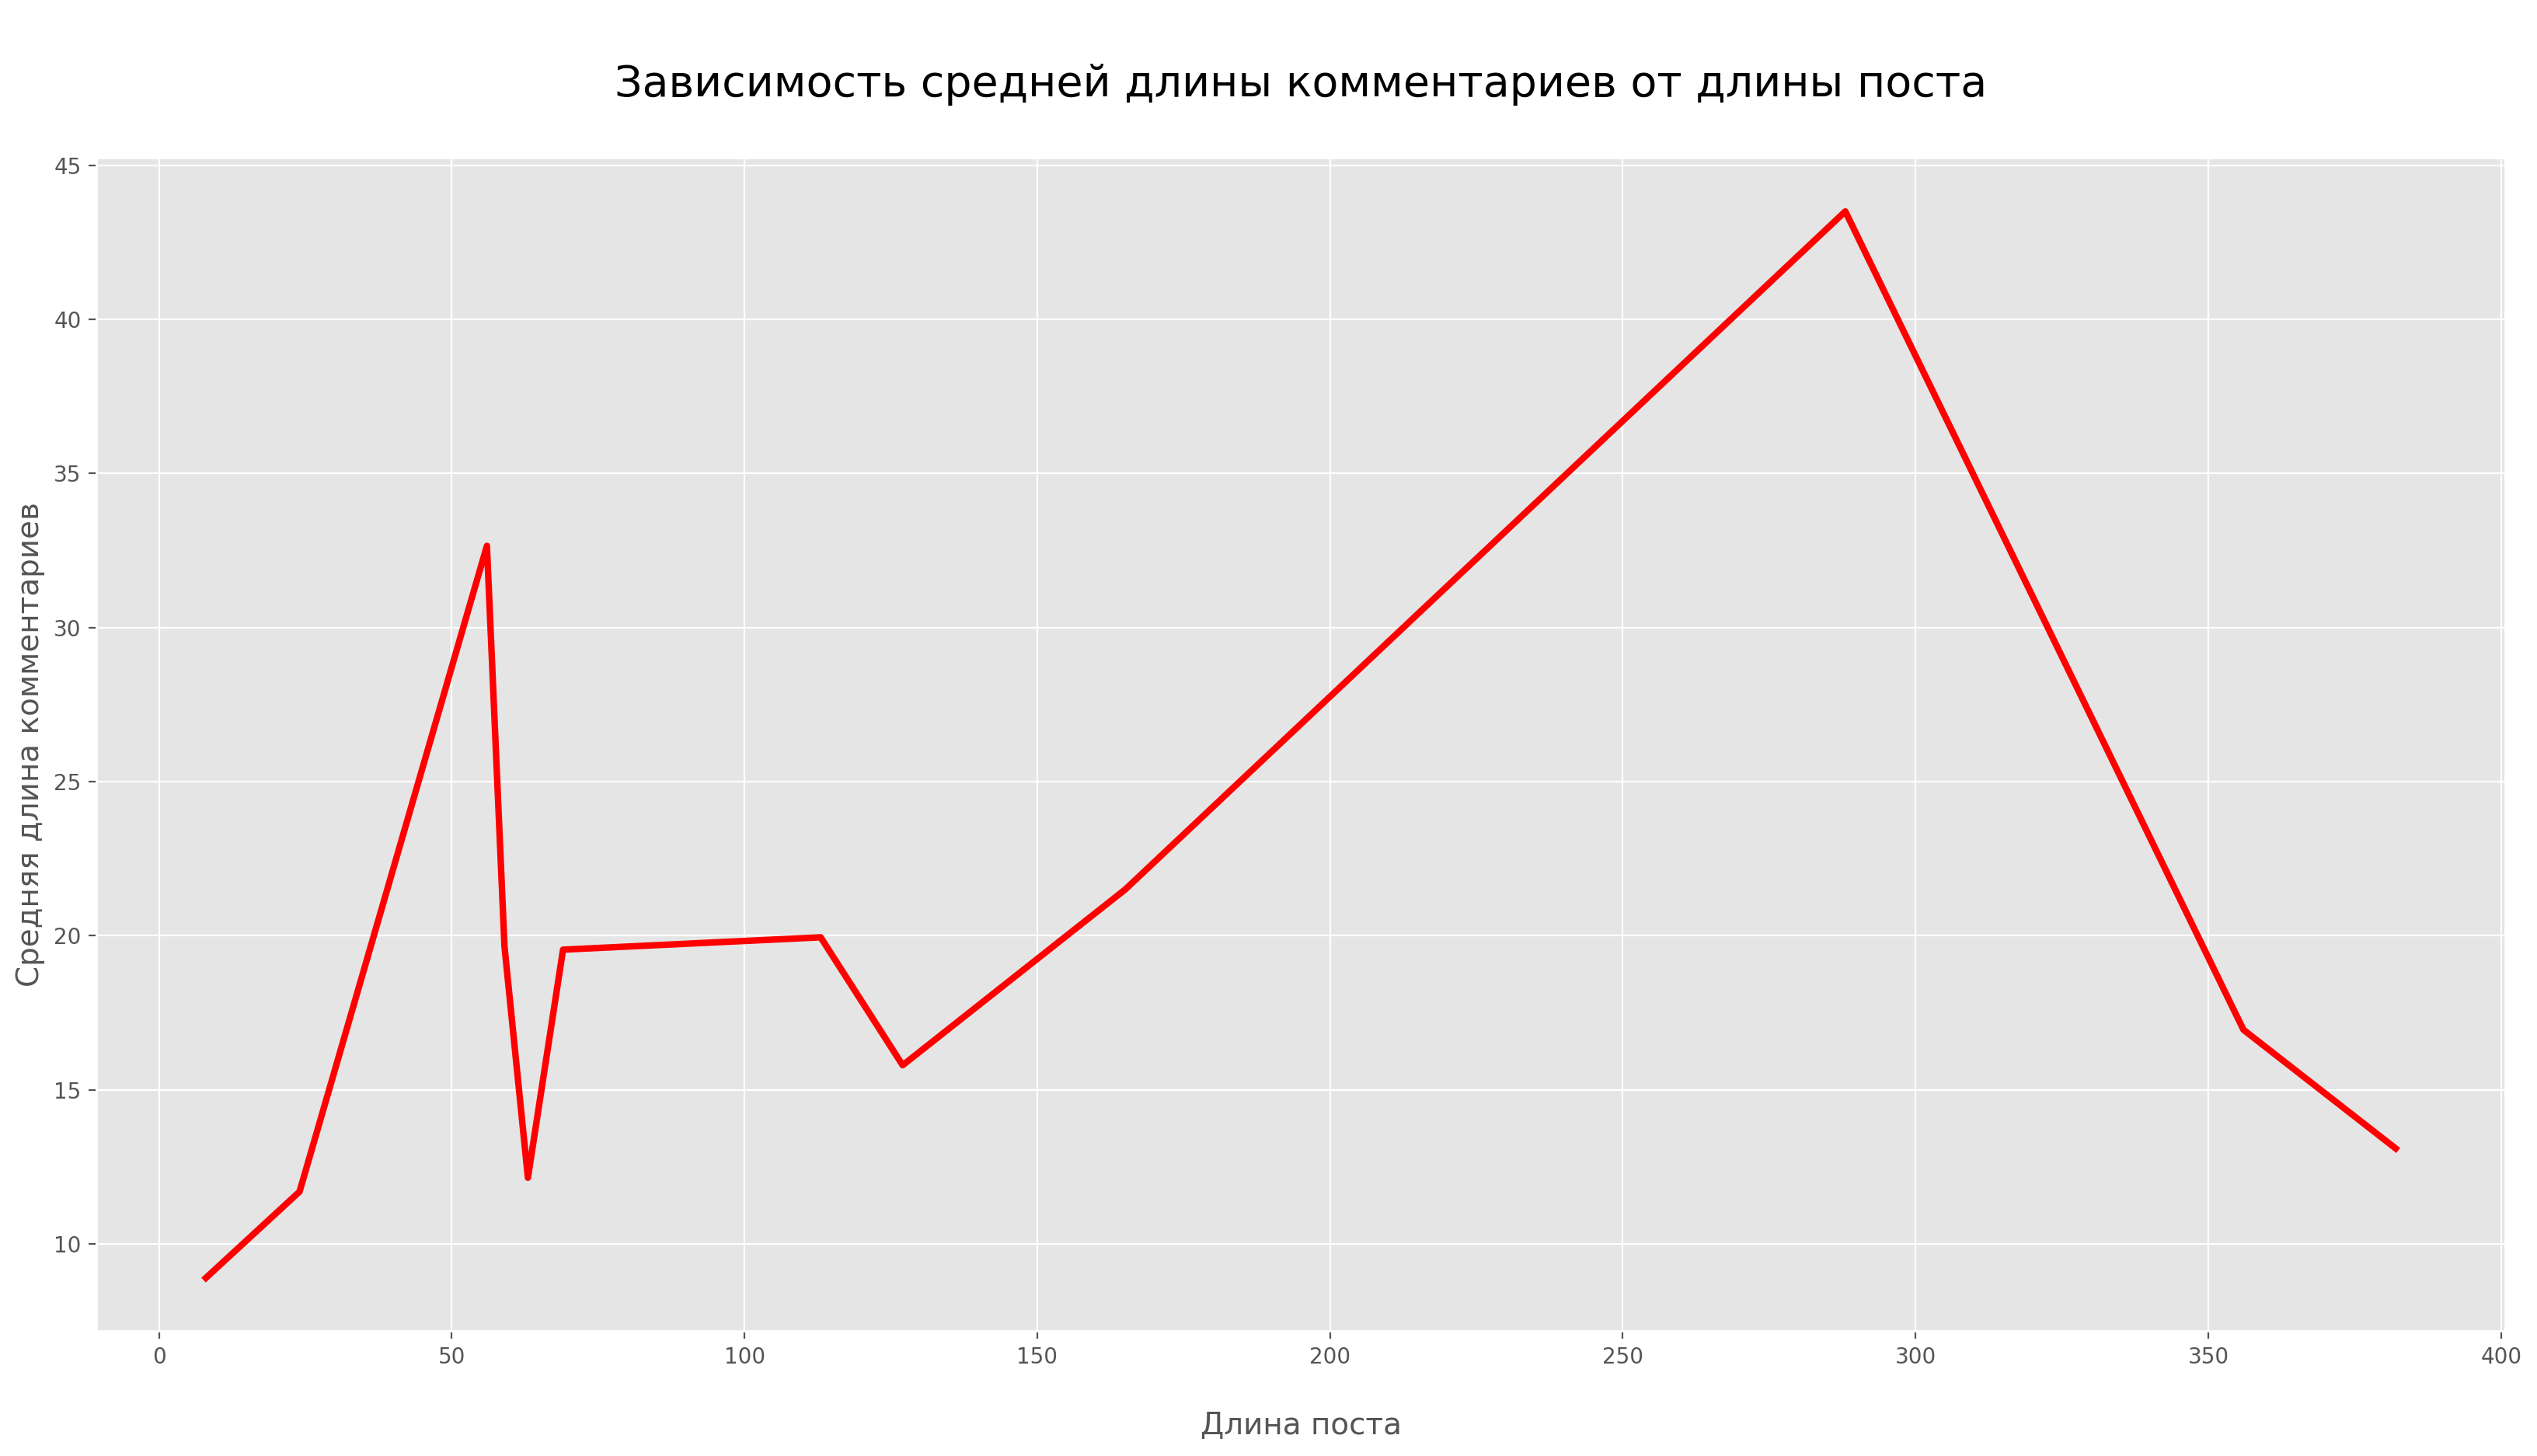

In [910]:
def graph1():
    length_post = {}
    graph = {}
    for_x = []
    for_y = []
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT * FROM alldata"):
       # print(row[0], row[1], row[2])
        length_post[row[0]] = row[2]
    con.commit()
    con.close()
   # print(length_post)
    for key, value in length_post.items():
        post_id = (int(key),)
        post = value
      #  print(post_id, post)
        con_2 = sqlite3.connect("posts.db") # открываем базу данных
        c_2 = con_2.cursor()
        c_2.execute('SELECT post_id, text_comment, length_comment FROM comments WHERE post_id=?', post_id)
        for_comments = c_2.fetchall()
        #print(for_comments)
        middle_com = 0
        #print(len(for_comments))
        for i in for_comments:
            middle_com += int(i[2])
            print(i)
            graph[i[0]] = [post, middle_com/int(len(for_comments))]
       # print(middle_com)
        con_2.close()
    print(graph)
    grafic = sorted(graph.items(), key=lambda x: x[1], reverse=False)
   # print(grafic)
    for i in grafic:
        print(i[1][0])
   # for key, value in graph.items():
        for_x.append(i[1][0])
        for_y.append(i[1][1])
    print(for_x, '\n', for_y)
    style.use('ggplot')
    plt.figure(figsize=(20, 10), dpi=200)
    plt.plot(for_x, for_y, linewidth=3, color='r')
    plt.title('\nЗависимость средней длины комментариев от длины поста\n',  fontsize=20)
    plt.ylabel('Средняя длина комментариев',  fontsize=14)
    plt.xlabel('\nДлина поста',  fontsize=14)
    #plt.xticks(x, posts_labs, rotation=90)
    #plt.bar(for_x, for_y)
    #plt.show()
    plt.savefig("Commentpost.png", dpi=200, fromat='png', bbox_inches='tight')
    #plt.clf()
     
graph1() 

{1: 0, 2: 0, 3: 0, 4: 0, 5: 70.16666666666667, 6: 8.0, 7: 190.14285714285714}
week_nums [0, 0, 0, 0, 70.16666666666667, 8.0, 190.14285714285714] 190.14285714285714
['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
понедельник 0
вторник 0
среда 0
четверг 0
пятница 70.16666666666667
70.17
суббота 8.0
8.0
воскресенье 190.14285714285714
190.14
{1: 0, 2: 177.25, 3: 57.0}
hour_nums [0, 177.25, 57.0] 177.25
['00:00-07:59', '08:00-15:59', '16:00-23:59']
00:00-07:59 0
08:00-15:59 177.25
177.25
16:00-23:59 57.0
57.0


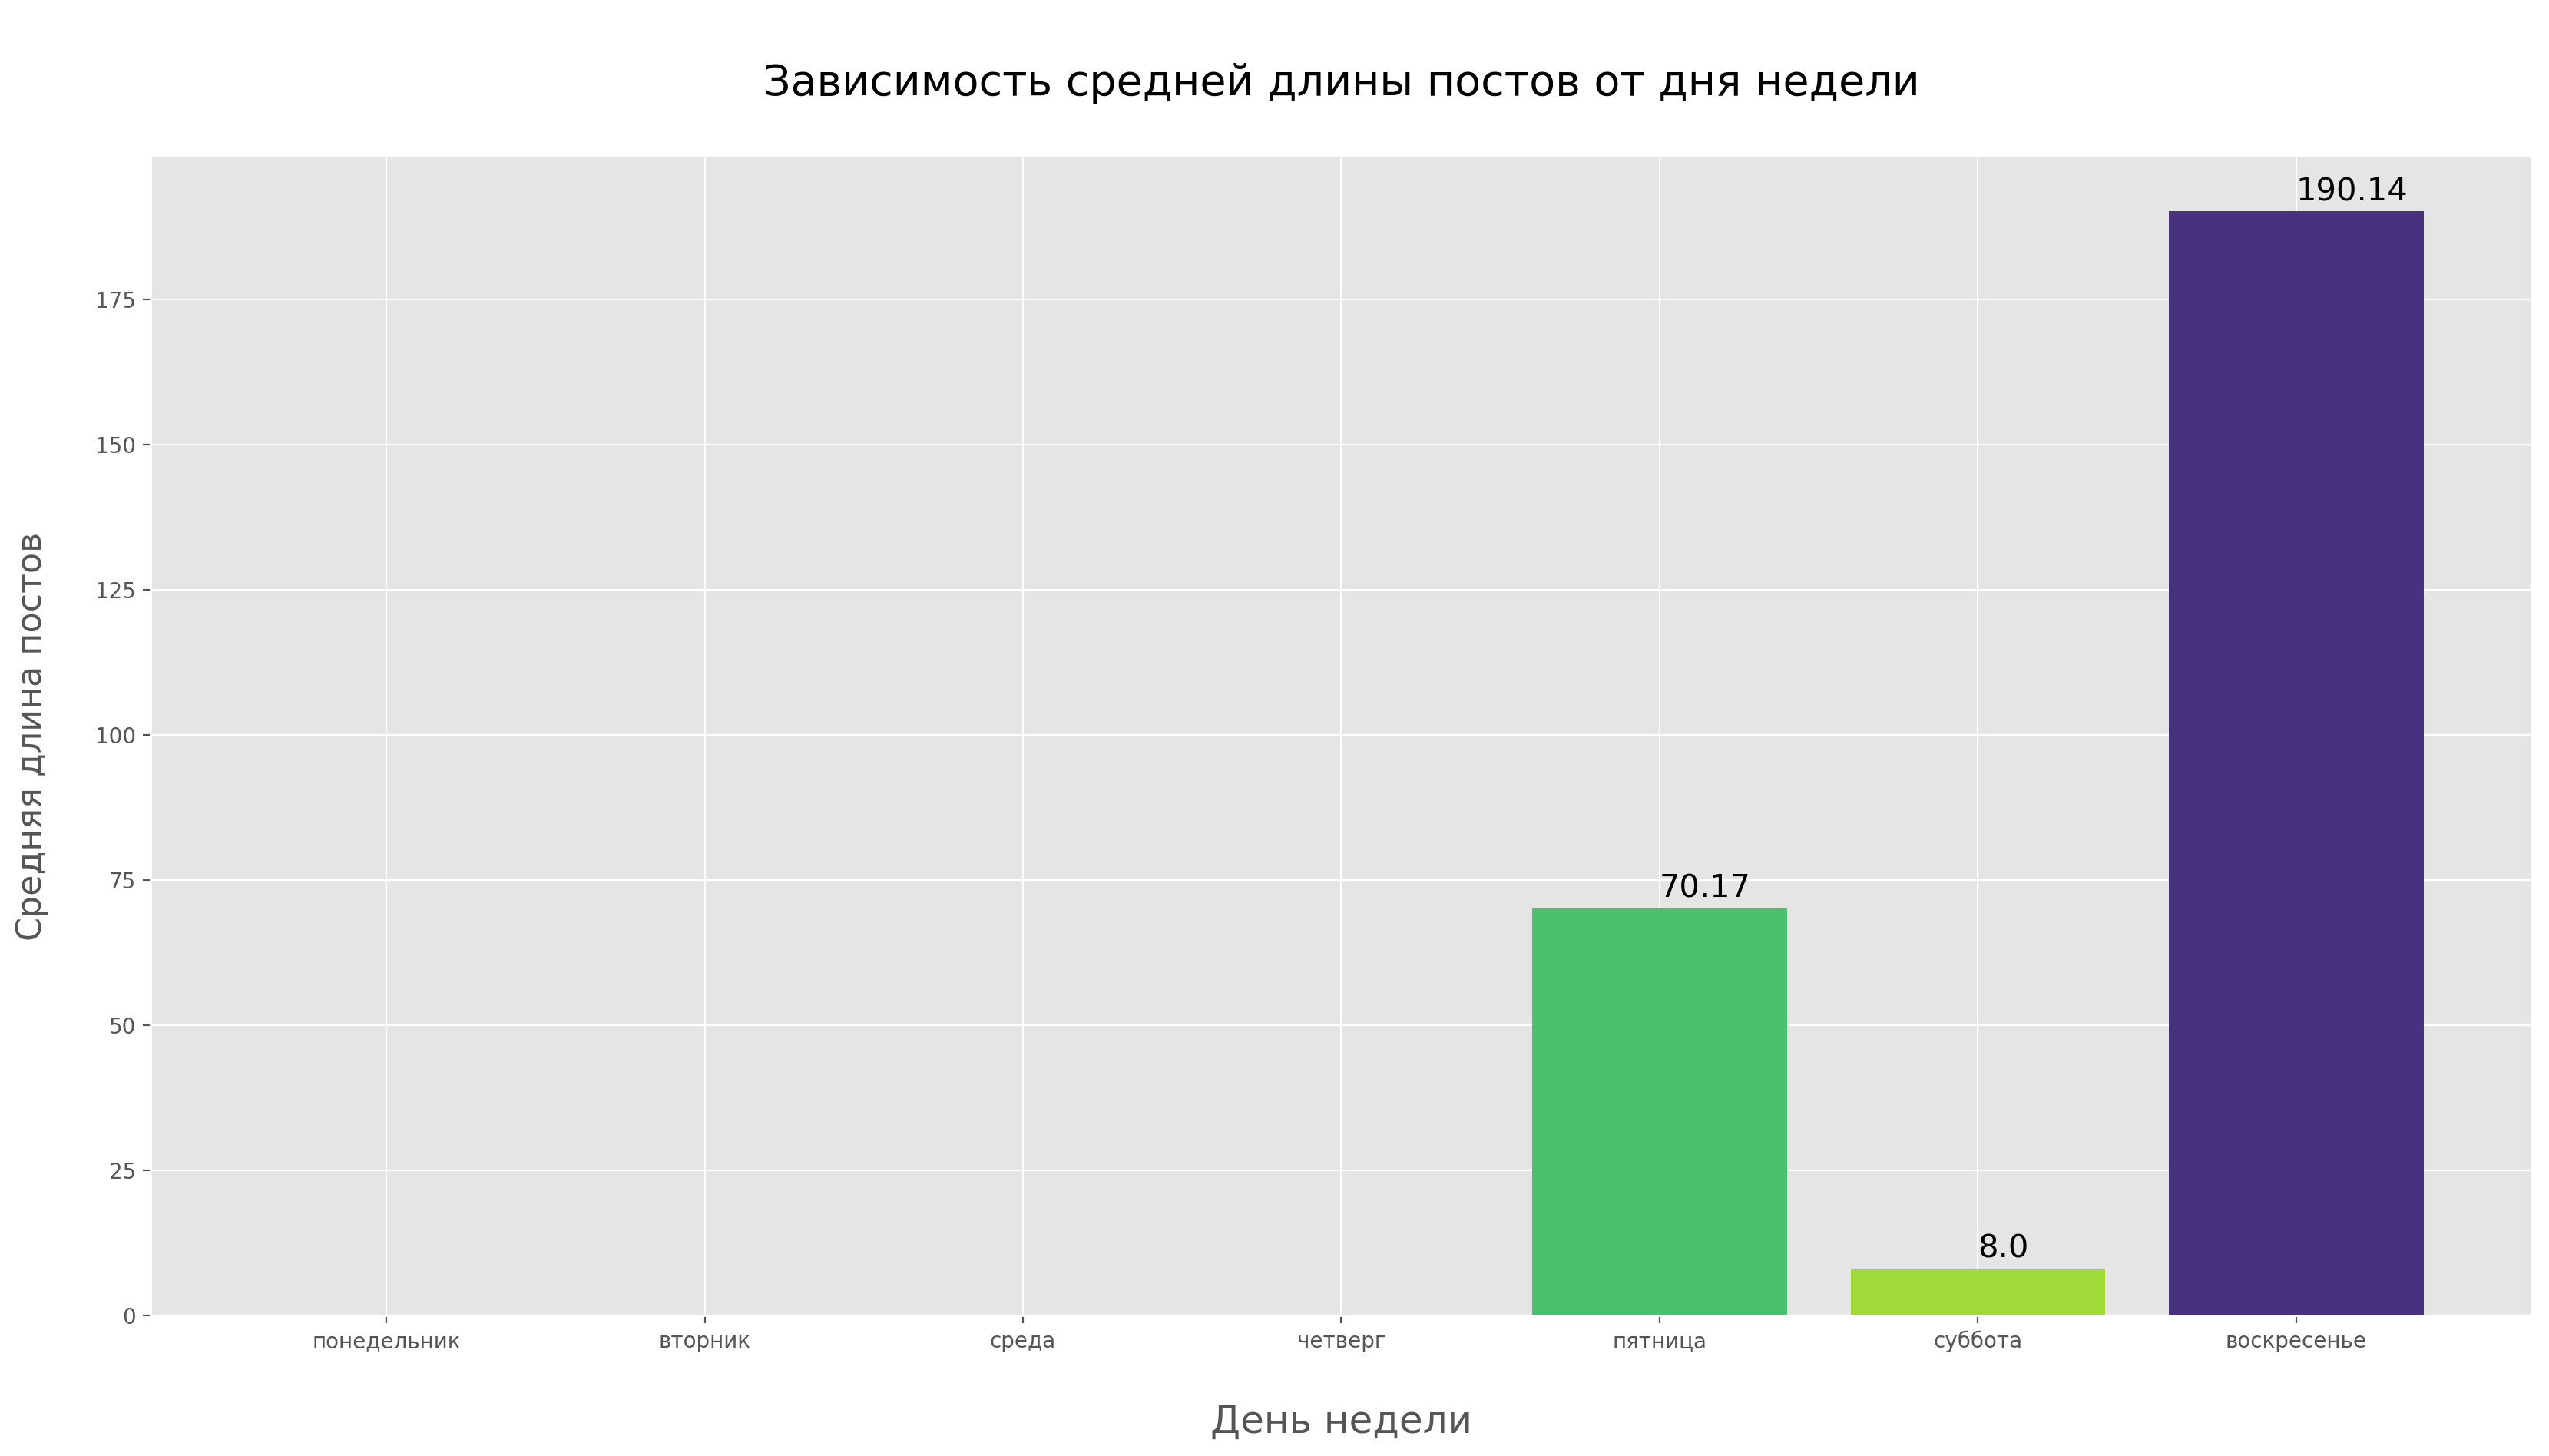

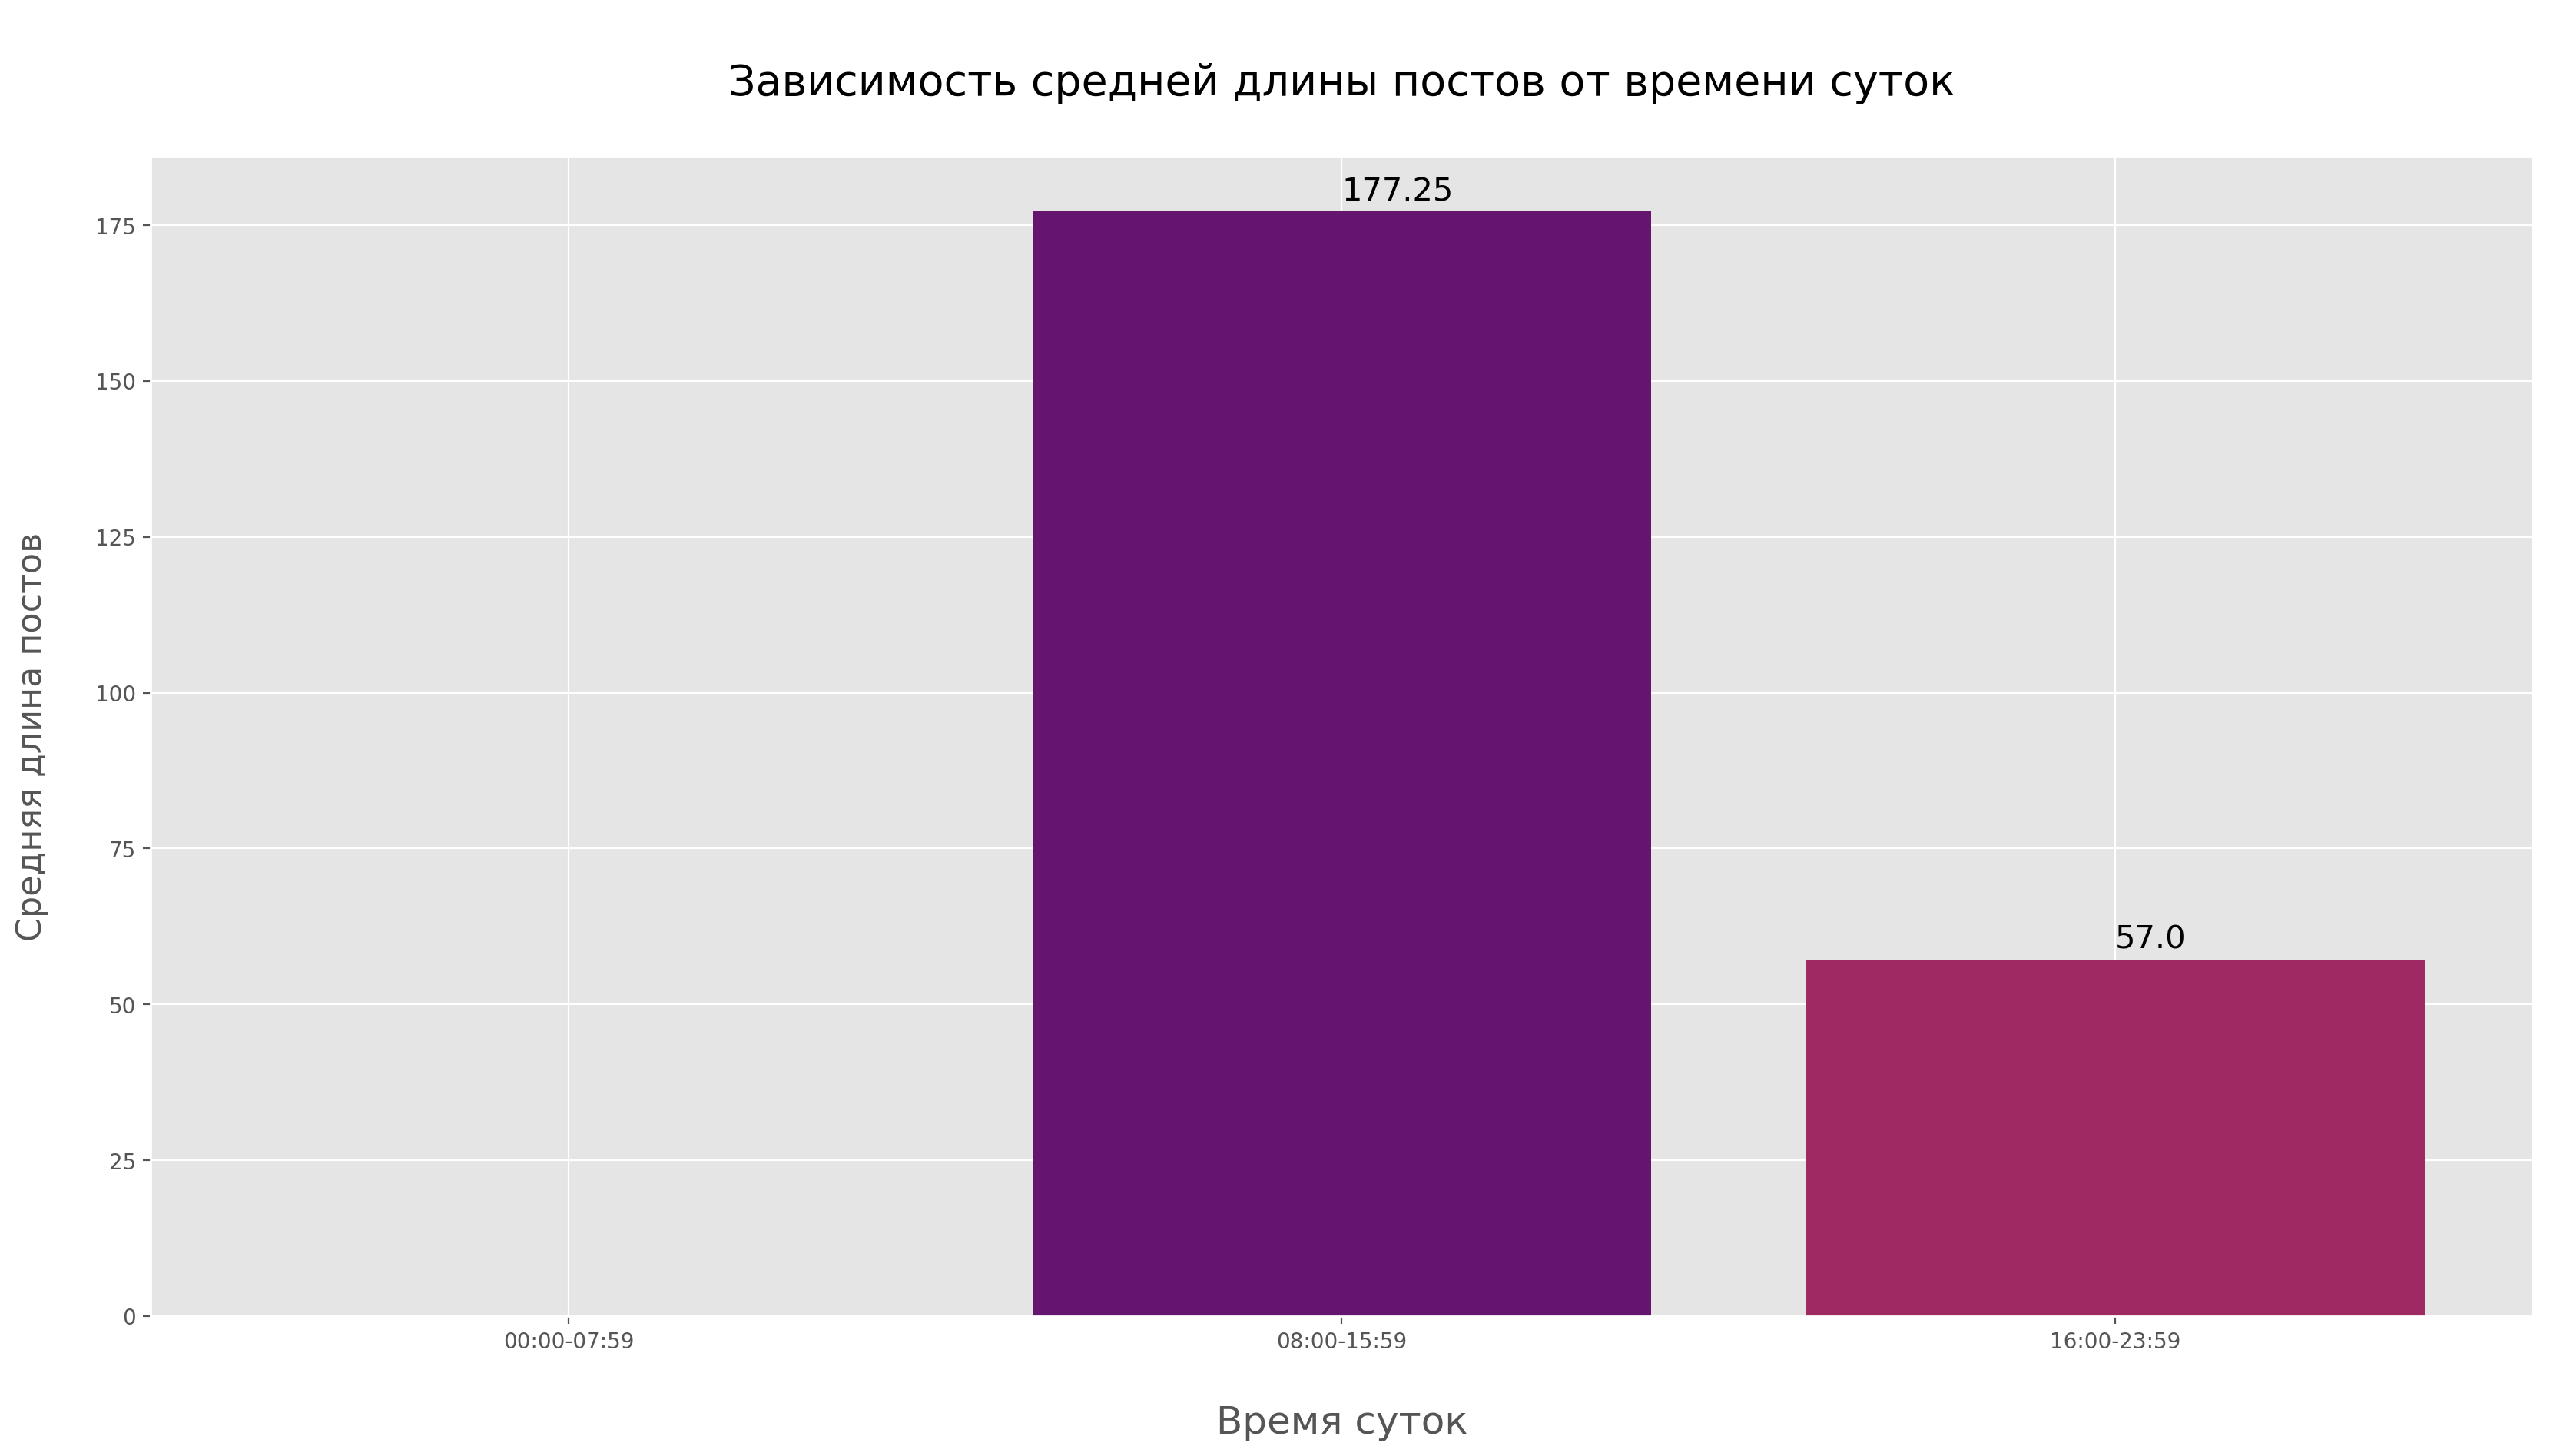

In [911]:
def graph23():
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    weeks = {}
    hours = {}
    week_days = [1, 2, 3, 4, 5, 6, 7]
    time_hours = [1, 2, 3]
    day_names = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
    hour_names = ['00:00-07:59', '08:00-15:59', '16:00-23:59']
    #for row in c.execute("SELECT * FROM alldata"):
      #  print(row)
    for one_day in week_days:
        c.execute('SELECT post_id, text_post, lenght_post, week FROM alldata WHERE week=?', (int(one_day),))
        for_week = c.fetchall()
        length = 0
        for post in for_week:
            length += int(post[2])
        #    print(post[1], post[2], '\n******************\n')
        if len(for_week) == 0:
            middle = 0
        else:
            middle = length/int(len(for_week))
        weeks[one_day] = middle
      #  print(one_day, '\n------\n', len(for_week), '\n------------\n', length, middle)
    con.close()
    print(weeks)
    #print(sorted(weeks.items(), key=lambda x: x[1], reverse=True))
    style.use('ggplot')
    week_nums = [c[1] for c in weeks.items()] # данные по оси y
    print('week_nums', week_nums, max(week_nums))
    week_labs = [dweek for dweek in day_names] # подписи по оси x
    print(week_labs)
    #x = []#range(len(week_labs)) # данные по оси x
    #print(x)
    colors = sns.color_palette('viridis')
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(week_labs, week_nums, color=colors)
    for a, b in zip(week_labs, week_nums):
        print(a, b)
        if b > 0:
            print(round(b, 2))
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(round(b, 2)), fontsize=15)
    plt.title('\nЗависимость средней длины постов от дня недели\n',  fontsize=20)
    plt.ylabel('Средняя длина постов\n',  fontsize=16)
    plt.xlabel('\nДень недели',  fontsize=18)
    #plt.xticks(week_labs, week_labs, rotation=90)
    #plt.show()
    plt.savefig("Weekpost.png", dpi=200, fromat='png', bbox_inches='tight')
    
    con_2 = sqlite3.connect("posts.db") # открываем базу данных
    c_2 = con_2.cursor()
    for one_hour in time_hours:
       # print(one_hour)
        c_2.execute('SELECT * FROM alldata WHERE time_post=?', (str(one_hour),))
        all_time = (c_2.fetchall())
        length_time = 0
        #print(all_time)
        for for_time in all_time:
            length_time += int(for_time[2])
         #   print('\n\n------------\n\n', for_time[2], for_time[3])
        if len(all_time) == 0:
            middle_time = 0
        else:
            middle_time = length_time/int(len(all_time))
        #print(length_time, middle_time)
       # length = 0
        hours[one_hour] = middle_time
    con_2.close()
    print(hours)
    style.use('ggplot')
    hours_nums = [c[1] for c in hours.items()] # данные по оси y
    print('hour_nums', hours_nums, max(hours_nums))
    hours_labs = [dhour for dhour in hour_names] # подписи по оси x
    print(hours_labs)
    colors_2 = sns.color_palette('inferno')
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(hours_labs, hours_nums, color=colors_2)
    for a, b in zip(hours_labs, hours_nums):
        print(a, b)
        if b > 0:
            print(round(b, 2))
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(round(b, 2)), fontsize=15)
    plt.title('\nЗависимость средней длины постов от времени суток\n',  fontsize=20)
    plt.ylabel('Средняя длина постов\n',  fontsize=16)
    plt.xlabel('\nВремя суток',  fontsize=18)
    #plt.xticks(week_labs, week_labs, rotation=90)
    #plt.show()
    plt.savefig("Hourspost.png", dpi=200, fromat='png', bbox_inches='tight')
    
graph23()



^^^^^^^^^^^^^^^^^ 1062 

 27.94736842105263


^^^^^^^^^^^^^^^^^ 3557 

 18.526041666666668
{'male': 27.95, 'female': 18.53}
sex_nums [27.95, 18.53] 27.95
['male', 'female']
male 27.95
27.95
female 18.53
18.53


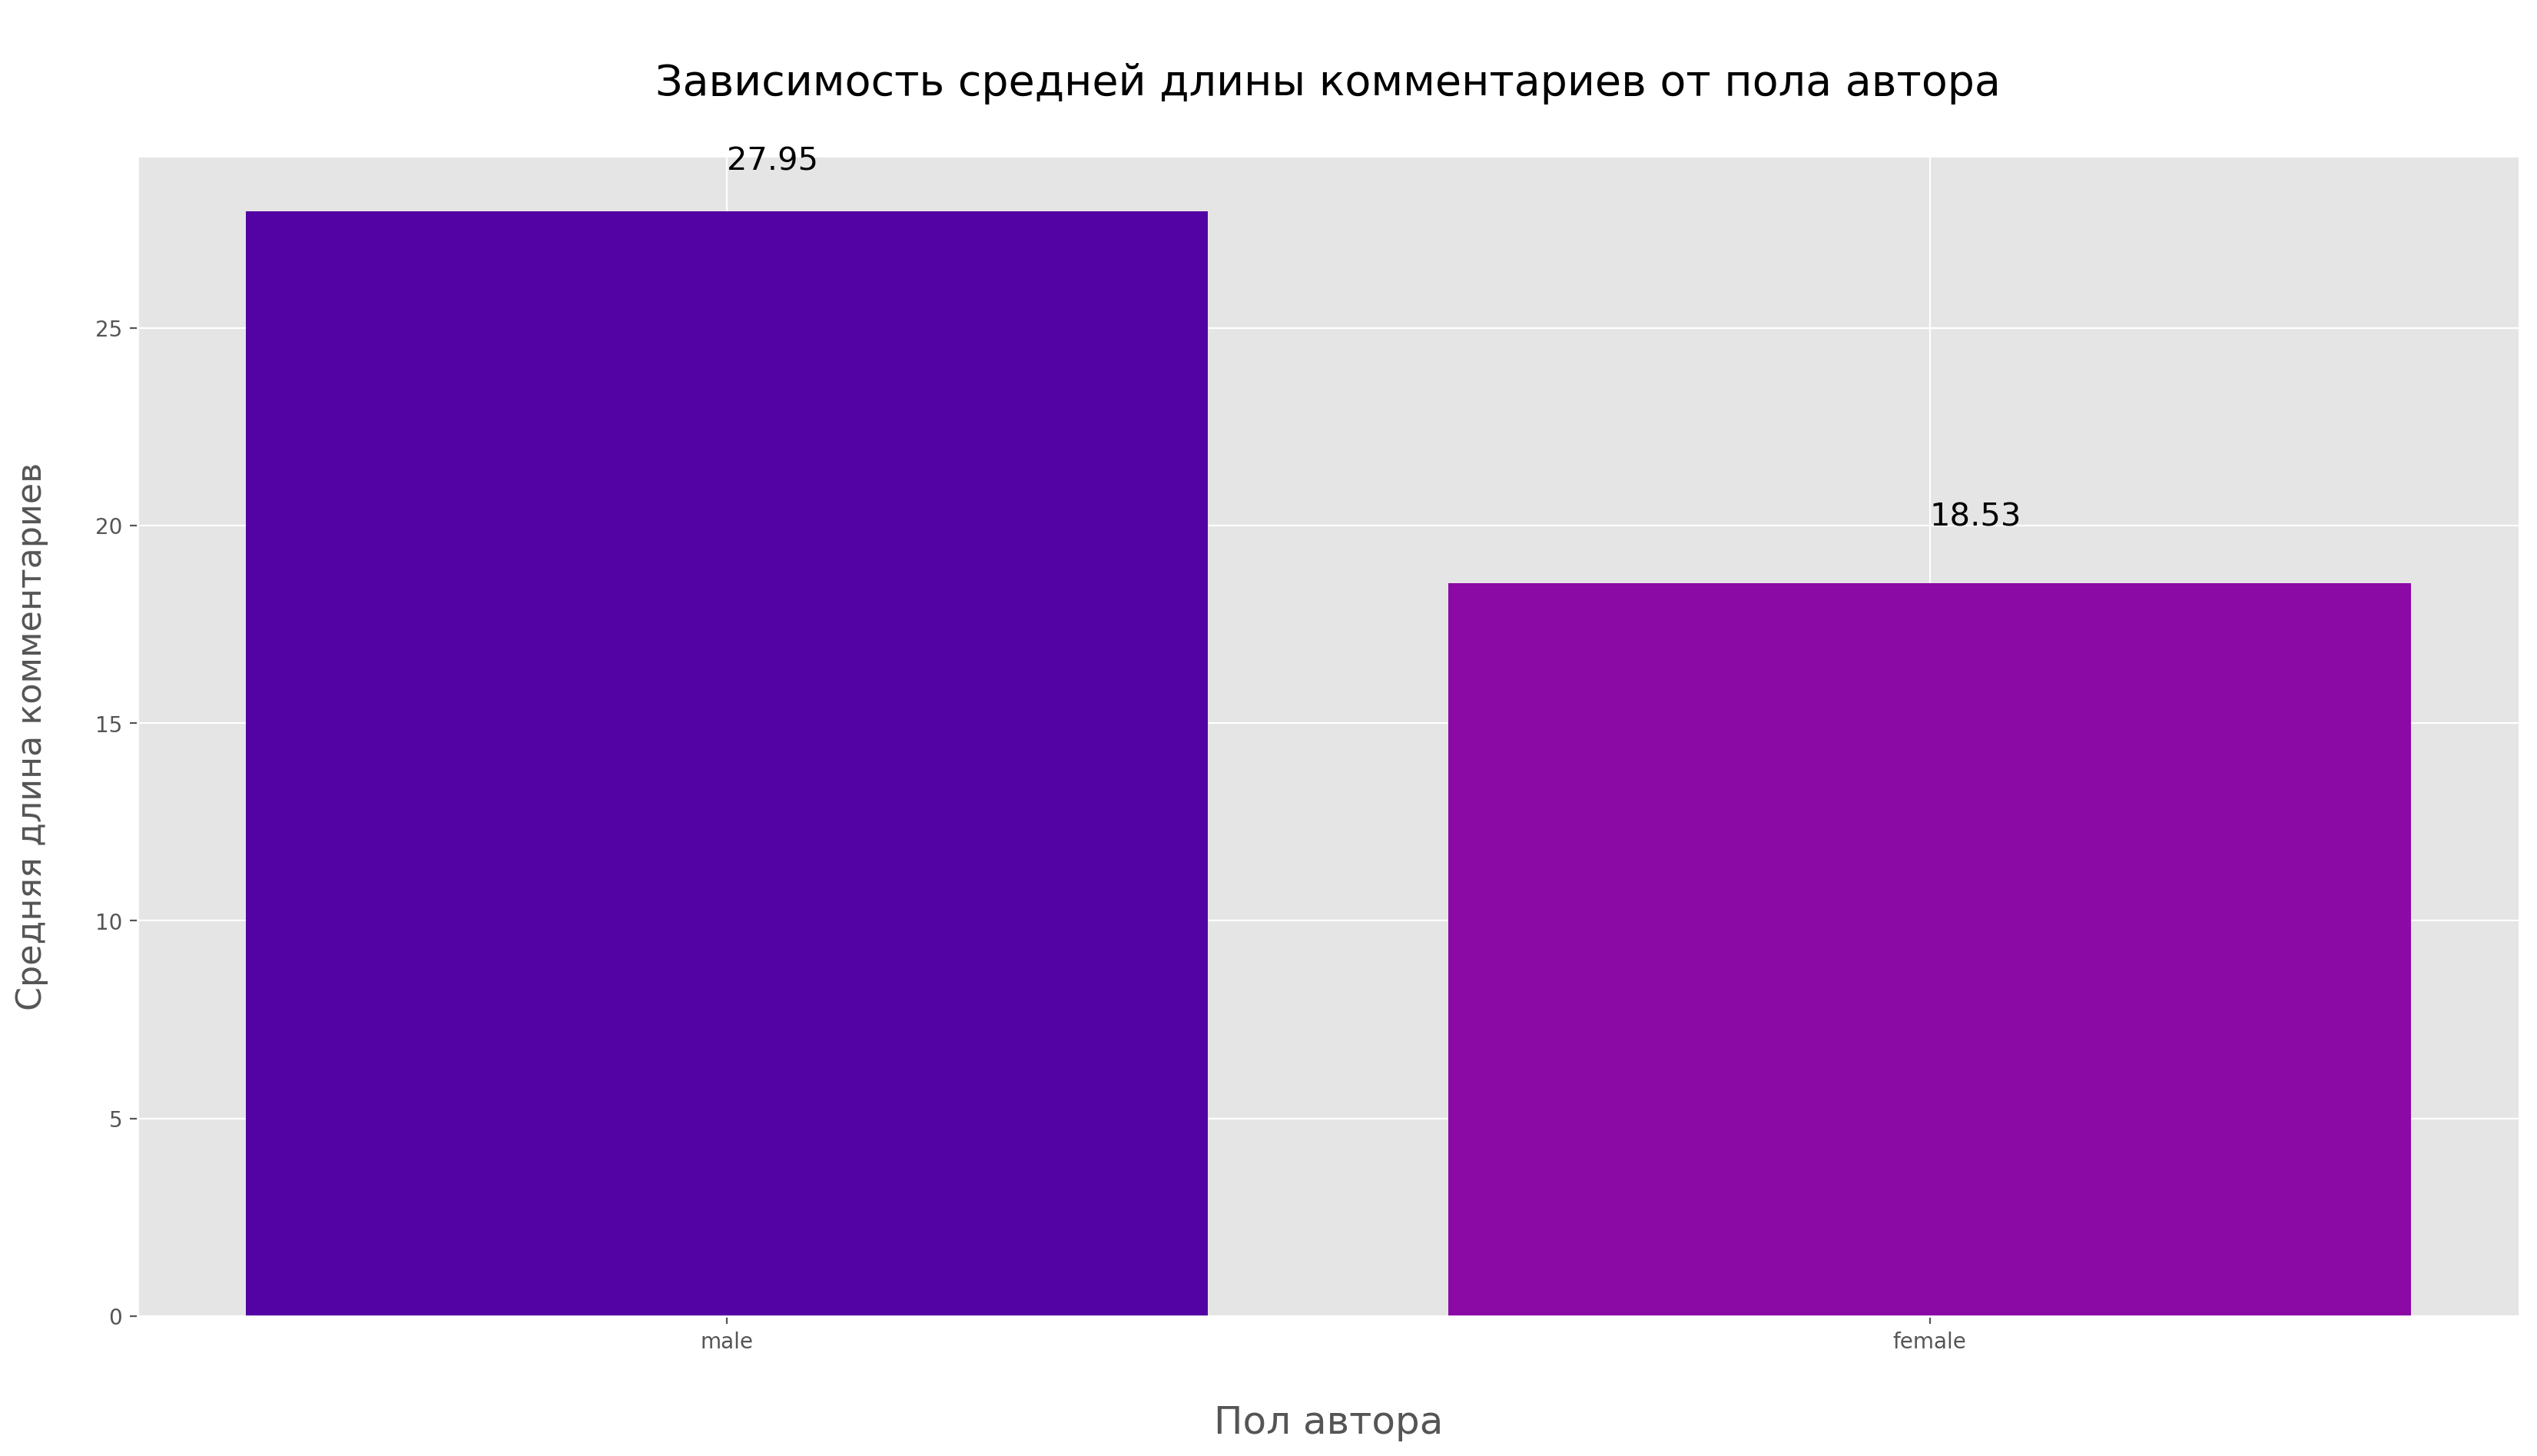

In [912]:
def graph4():
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    sex_list = ['male', 'female']
    sex = {}
    for per in sex_list:
    #    print(per)
        c.execute('SELECT * FROM comments WHERE sex=?', (str(per),))
        for_sex = c.fetchall()
        length = 0
        for person in for_sex:
            length += int(person[2])
          #  print(person[0], person[1], '\n---', person[2], person[6])
        if len(for_sex) == 0:
            middle_sex = 0
        else:
            middle_sex = length/int(len(for_sex))
        print('\n\n^^^^^^^^^^^^^^^^^', length,'\n\n', middle_sex)
        sex[per] = round(middle_sex, 2)
    con.close() 
    print(sex)
    style.use('ggplot')
    sex_nums = [c[1] for c in sex.items()] # данные по оси y
    print('sex_nums', sex_nums, max(sex_nums))
    sex_labs = [dsex for dsex in sex_list] # подписи по оси x
    print(sex_labs)
    colors = sns.color_palette('plasma')
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(sex_labs, sex_nums, color=colors)
    for a, b in zip(sex_labs, sex_nums):
        print(a, b)
        if b > 0:
            print(b)
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(b), fontsize=15)
    plt.title('\nЗависимость средней длины комментариев от пола автора\n',  fontsize=20)
    plt.ylabel('Средняя длина комментариев\n',  fontsize=16)
    plt.xlabel('\nПол автора',  fontsize=18)
    #plt.xticks(week_labs, week_labs, rotation=90)
    #plt.show()
    plt.savefig("Sexcomment.png", dpi=200, fromat='png', bbox_inches='tight')
    
graph4()

[('Mukhranovo', 526.0), ('Mytischi', 86.0), ('Barnaul', 68.0), ('Sergiev Posad', 64.0), ('Bratsk', 59.0), ('Vitebsk', 50.0), ('Blagoveschensk', 47.0), ('Ufa', 46.5), ('Seversk', 39.0), ('Münster', 37.0), ('Obninsk', 34.0), ('Krasnodar', 32.0), ('Alexeevka', 32.0), ('Ivanovo', 32.0), ('Feodosia', 31.5), ('Astrakhan', 31.0), ('Rybinsk', 30.0), ('Sosensky', 28.0), ('Nizhny Novgorod', 25.67), ('Orenburg', 25.0), ('Karmiel', 25.0), ('None', 23.56), ('Magnitogorsk', 23.0), ('Sevastopol', 23.0), ('Tver', 22.0), ('Minsk', 21.75), ('Miass', 20.0), ('Petrozavodsk', 20.0), ('Stavropol', 20.0), ('Gomel', 19.0), ('Vladikavkaz', 19.0), ('Dzerzhinsk', 19.0), ('Nevinnomyssk', 18.0), ('Biruintsa', 18.0), ('Saransk', 16.0), ('Kemerovo', 16.0), ('Tiraspol', 15.0), ('Engels', 15.0), ('Moscow', 14.67), ('Ekaterinoslavka', 14.0), ('Tikhoretsk', 14.0), ('Kungur', 14.0), ('Tolyatti', 13.0), ('Leninogorsk', 13.0), ('Omsk', 12.5), ('Rostov-on-Don', 12.5), ('Samara', 12.0), ('Lyon', 12.0), ('Chesma', 11.5), ('Vo

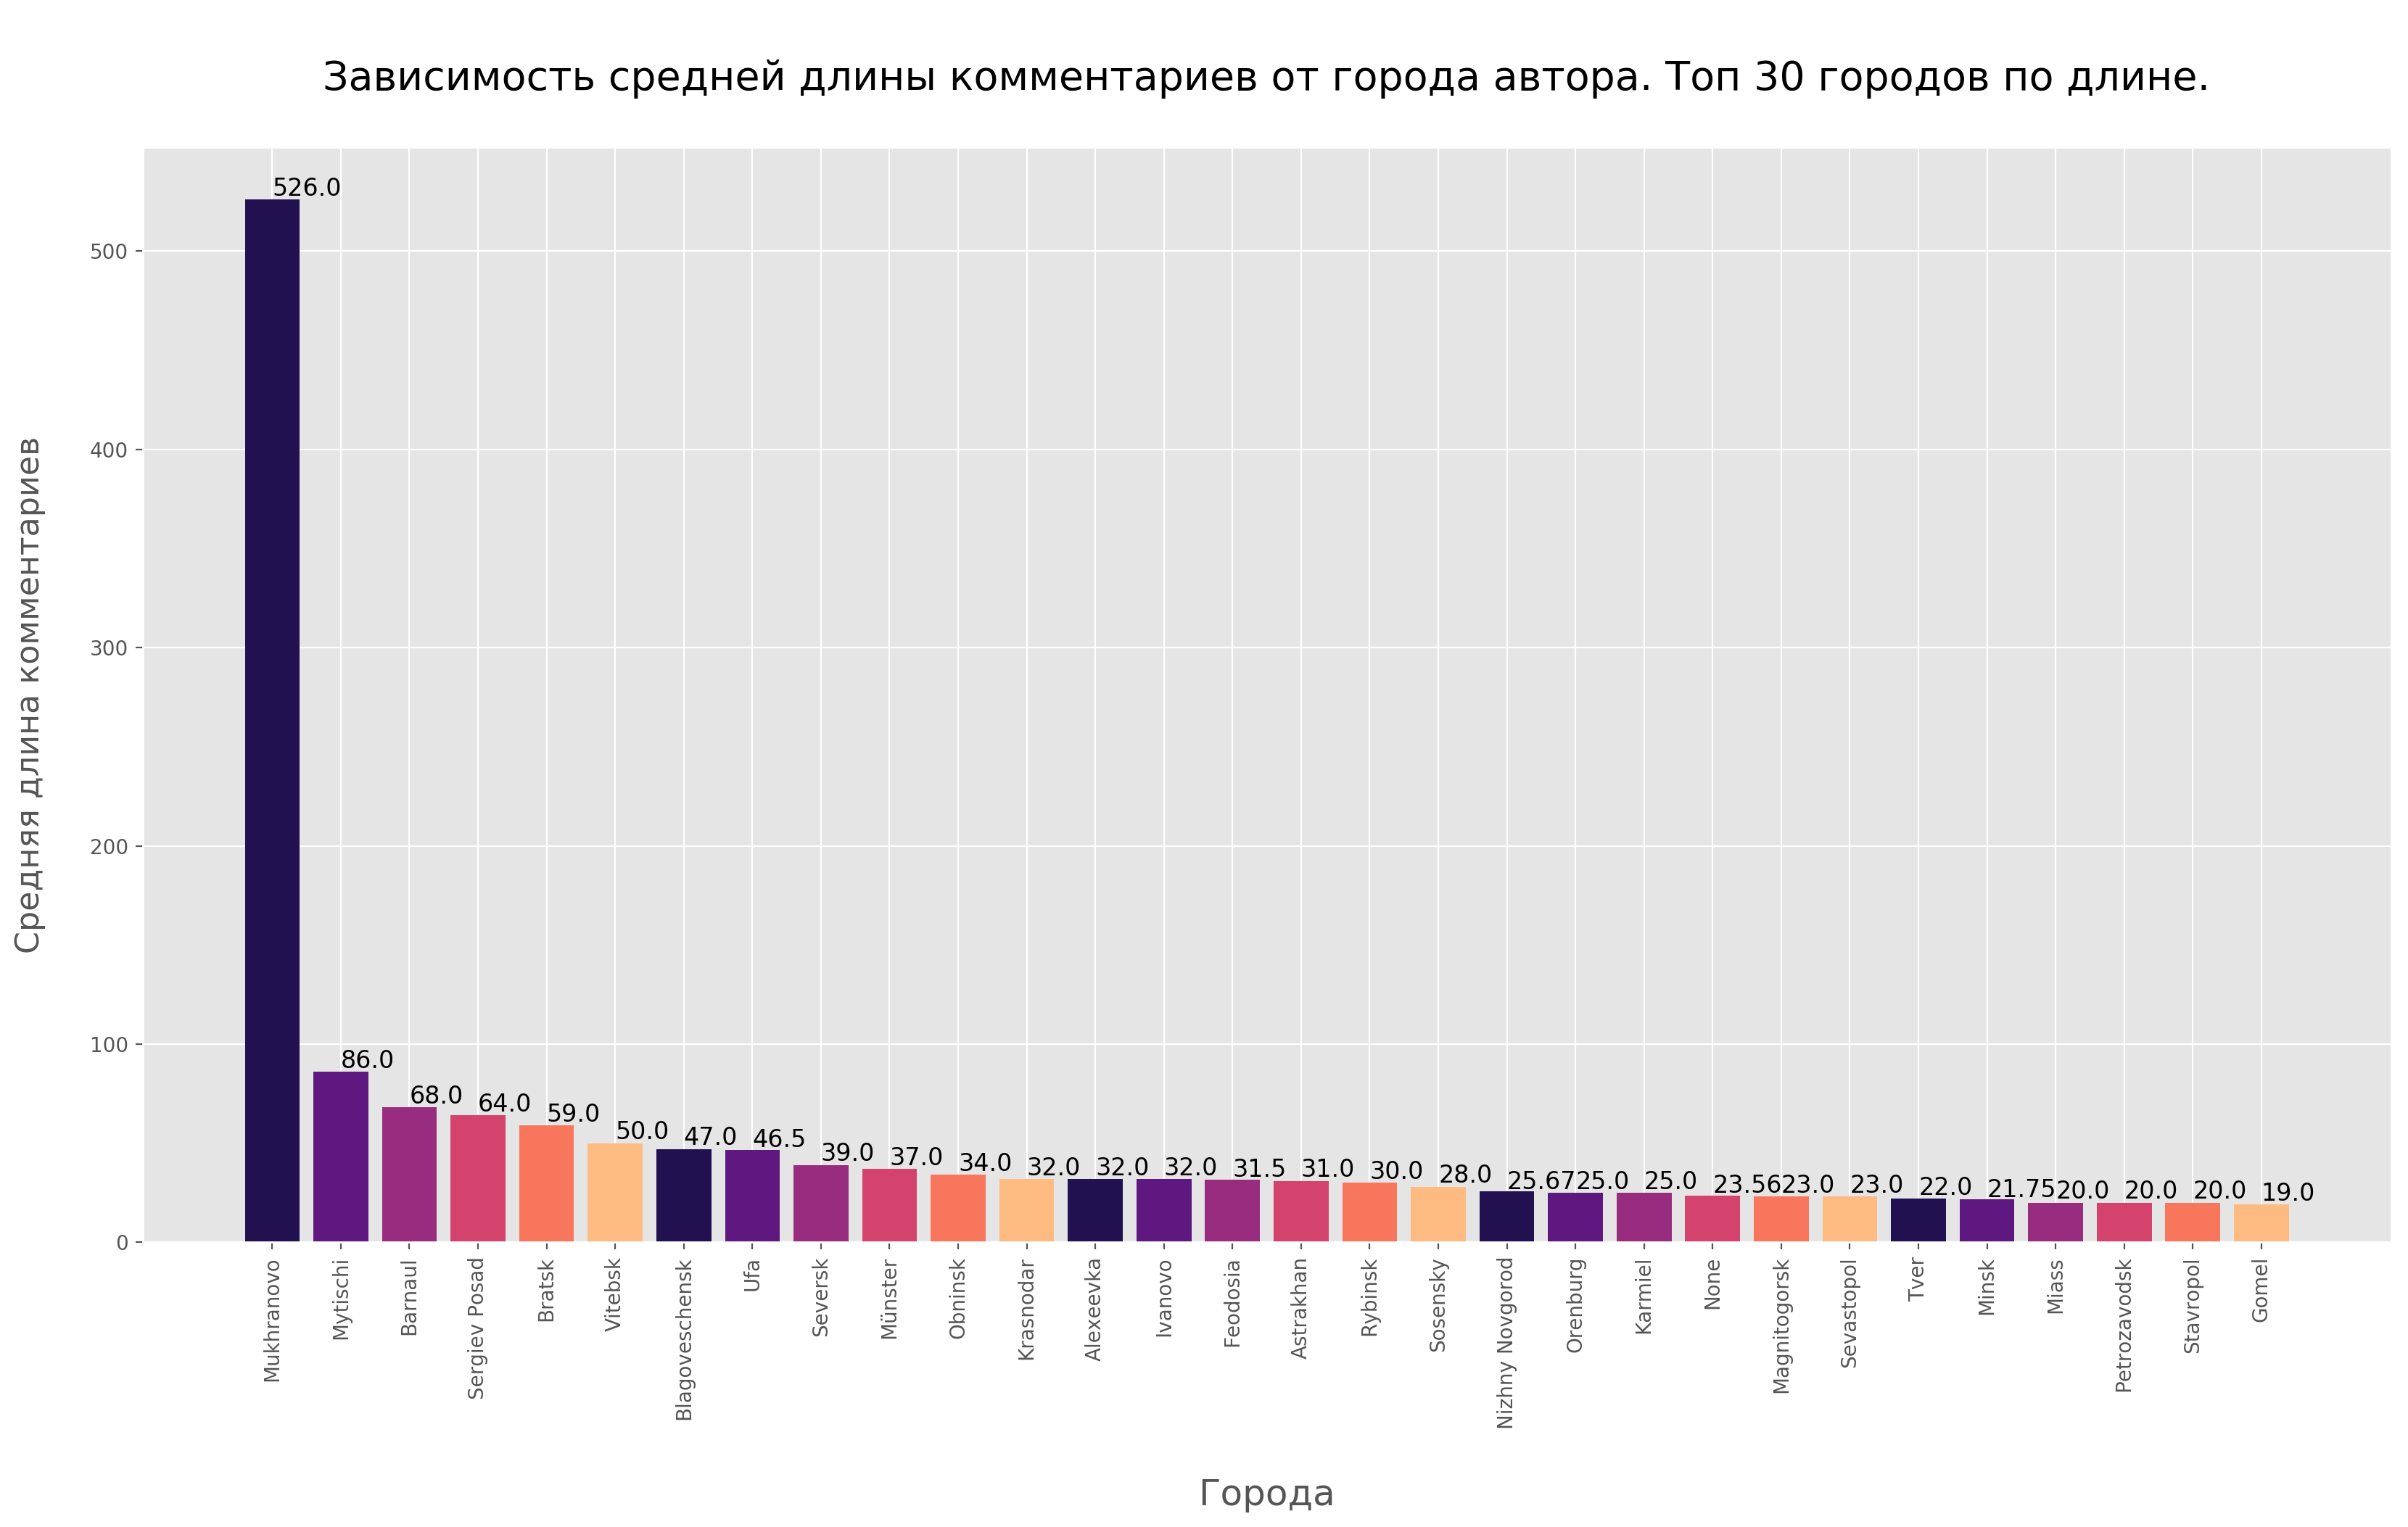

In [913]:
def graph5():
    cities_1 = {}
    city_f = {}
    con = sqlite3.connect("posts.db") # открываем базу данных
    c = con.cursor()
    for row in c.execute("SELECT * FROM comments"):
       # print(row[0], row[1], row[2], row[4])
        if row[4] in cities_1:
            cities_1[row[4]] += 1
        else:
            cities_1[row[4]] = 1
        #cities[row[4]] = row[2]
    con.close()
   # print(cities_1)
    for key, value in cities_1.items():
        city = key
      #  print(city)
        con_2 = sqlite3.connect("posts.db") # открываем базу данных
        c_2 = con_2.cursor()
        c_2.execute('SELECT * FROM comments WHERE city=?', (str(city),))
        for_city = c_2.fetchall()
     #   print(for_city)
        length_com = 0
        for one_city in for_city:
            length_com += int(one_city[2])
      #      print('\n\n________', one_city[2], one_city[4])
    #    print(length_com, len(for_city))
        if len(for_city) == 0:
            middle_city = 0
        else:
            middle_city = length_com/int(len(for_city))
        #print(middle_city)
        con_2.close()
      #  print(middle_city)
        city_f[city] = round(middle_city, 2)
    print( sorted(city_f.items(), key=lambda x: x[1], reverse=True))
    
    
    style.use('ggplot')
    city_nums = [c[1] for c in sorted(city_f.items(), key=lambda x: x[1], reverse=True)] # данные по оси y
    print('city_nums', city_nums)
    colors = sns.color_palette('magma')
  #  city_nums = [c[1] for c in sorted(cities.items(), key=lambda x: x[0], reverse=False)] # данные по оси y

    
    city_labs = [c_1[0] for c_1 in sorted(city_f.items(), key=lambda x: x[1], reverse=True)] # подписи по оси x
    print(city_labs)
    
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(city_labs[:30], city_nums[:30], color=colors)
    for a, b in zip(city_labs[:30], city_nums[:30]):
        print(a, b)
        if b > 0:
            print(b)
            plt.scatter(a, int(b), s=0)
            plt.text(a, int(b)+2, str(b), fontsize=12)
    plt.title('\nЗависимость средней длины комментариев от города автора. Топ 30 городов по длине.\n',  fontsize=20)
    plt.ylabel('Средняя длина комментариев\n',  fontsize=16)
    plt.xlabel('\nГорода',  fontsize=18)
    plt.xticks(city_labs[:30], city_labs[:30], rotation=90)
    #plt.show()
    plt.savefig("Citycomment.png", dpi=200, fromat='png', bbox_inches='tight')
    
    
graph5()

In [961]:
def graph6():
    word_dict = {}
    file_names = []
    final_line = []
    for_search = ''
    start_path = './plain_postsVK/'
    stop_file = './rus_stop.txt'
    with open(stop_file, 'r', encoding='utf-8') as fi:
        st_text = fi.read()
  #  print(st_text)
    stop_words = st_text.split()
    #print(stop_words)
    for root, dirs, files in os.walk(start_path):
        for file in files:
           #print(file)
          #  name_file = re.compile(r'(post_\d+.txt)', re.DOTALL)
            if "lem" not in file:
              #  print(file)
           #     print('\n\n________', file)
                final = os.path.join(root, file)
                file_names.append(final)
  #  print(file_names)
    for norm_file in file_names:
   #     print(norm_file)
        with open(norm_file,'r', encoding='utf-8') as f:
            text = f.read()
       # print(text)
        for_search += text + '\n'
   # print(for_search)
    final_str = for_search.lower()
    
    clean_t = re.sub(r'[а-яА-ЯёЁ](-)[а-яА-ЯёЁ]', '', final_str)
    clean = re.findall(r'[а-яА-ЯёЁ]+', clean_t)
    print(clean)
    for word in clean:
        for elem in stop_words:
            if elem != word:
                final_line.append(word)
    print(final_line)
   #     if word in word_dict:
   #         word_dict[word] += 1
   #     else:
   #         word_dict[word] = 1
   # print(sorted(word_dict.items(), key=lambda x: x[1], reverse=True))
graph6()

['ш', 'х', 'и', 'м', 'т', 'яблопользователи', 'н', 'уделал', 'ваше', 'ябло', 'о', 'а', 'с', 'та', 'ой', 'ценой', 'тем', 'более', 'каме', 'а', 'огонь', 'анонсирован', 'еплик', 'й', 'м', 'и', 'овации', 'п', 'оизводителям', 'и', 'безме', 'ная', 'благода', 'ность', 'м', 'газину', 'анонимно', 'помогите', 'советом', 'меня', 'бросили', 'на', 'пятом', 'месяце', 'беременности', 'не', 'угодила', 'его', 'матери', 'не', 'захотела', 'строить', 'свою', 'жизнь', 'по', 'её', 'правилам', 'она', 'сказала', 'что', 'ребёнок', 'им', 'не', 'нужен', 'и', 'чтобы', 'ноги', 'моей', 'у', 'них', 'не', 'было', 'выкинет', 'меня', 'на', 'улицу', 'если', 'приду', 'сына', 'мне', 'никогда', 'не', 'отдаст', 'он', 'её', 'послушал', 'и', 'бросил', 'нас', 'мне', 'ему', 'тоже', 'ну', 'и', 'на', 'тебе', 'нужен', 'этот', 'мамкин', 'сынок', 'избавилась', 'и', 'слава', 'богу', 'ну', 'значит', 'своих', 'мозгов', 'у', 'вашего', 'мужа', 'нет', 'и', 'своего', 'мнения', 'тоже', 'сынок', 'маменькин', 'только', 'вот', 'если', 'вы', 'з

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

